<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S6/MNIST_Assignment6-without-regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install the dependencies


In [2]:
!pip install torchsummary

### Import dependencies

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from torch.optim.lr_scheduler import StepLR

### Helper utilities

In [24]:
def isCuda():
  return torch.cuda.is_available()

def randInt(min, max, size): 
  return torch.LongTensor(size).random_(min, max)

def getDevice(): 
  return torch.device("cuda" if isCuda() else "cpu")

def showImages(images, labels, cols=10): 
  figure = plt.figure()
  num_of_images = len(images)
  rows = np.ceil(num_of_images/float(cols))
  for index in range(0, num_of_images):
    plt.subplot(rows, cols, index + 1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r') 
    plt.title(labels[index].item())

cpu = torch.device("cpu")
device = getDevice()
print(f'\nDevice: {device}')

# Set seed 
seed =1 
torch.manual_seed(seed)
if isCuda():
  torch.cuda.manual_seed(seed)



Device: cuda


### Transformations for Train and Test

In [0]:
def train_transformations(): 
  return transforms.Compose([         
                    transforms.RandomRotation((-7.0, 7.0), fill=(1,)), 
                    transforms.ToTensor(), 
                    transforms.Normalize((0.1307,), (0.3081,))])
  
def test_transformations(): 
  return transforms.Compose([
                    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

### Load train and test data

In [20]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if isCuda() else dict(shuffle=True, batch_size=64)

train_data = datasets.MNIST("../data", train=True, transform=train_transformations(), download=True)
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

test_data = datasets.MNIST("../data", train=False, transform=test_transformations(), download=True)
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

print(f'\nSize of train data:{train_data.data.shape}')
print(f'\nSize of test data:{test_data.data.shape}')


Size of train data:torch.Size([60000, 28, 28])

Size of test data:torch.Size([10000, 28, 28])


### View training/test data and their statistics


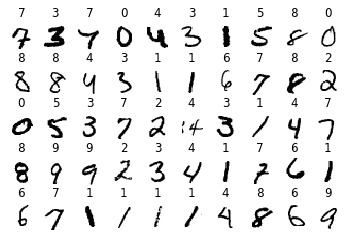

In [25]:
randImages = randInt(0, len(test_data.data), 50)
showImages(test_data.data[randImages], test_data.targets[randImages])

### Network architecture

In [8]:
class Net(nn.Module): 

  def __init__(self): 
    super(Net, self).__init__()

    drop_out = 0.04
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # RF - 3x3
        nn.ReLU(), 
        nn.BatchNorm2d(10),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # RF - 5x5
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out)
    ) # Output - 24 x 24

    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False), # RF - 5x5
        nn.MaxPool2d(2, 2), # # RF - 6x6
    ) # Output - 12 x 12

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # RF - 10x10
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # RF - 14x14
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # RF - 18x18
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=16, out_channels=15, kernel_size=(3, 3), padding=0, bias=False), # RF - 22x22
        nn.ReLU()
    ) # output = 4 x 4

    self.gap1 = nn.AdaptiveAvgPool2d(1) # RF - 28x28
    self.conv4 = nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), bias=False) # RF - 28x28

  def forward(self, x): 

    x = self.transition1(self.conv1(x))
    x = self.conv2(x)
    x = self.conv4(self.gap1(x))
    x = x.view(-1, 10)
    return F.log_softmax(x)

  def summarize(self, input): 
    summary(self, input_size=input)

Net().to(getDevice()).summarize((1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
        Dropout2d-14           [-1, 16,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### Utilities to compute metrics

In [0]:
def compute_accuracy(prediction, target): 
  return 100 * prediction.eq(target.view_as(prediction)).sum().item() / float(len(prediction))

def compute_miss(data, prediction, target): 
  corrects = prediction.eq(target.view_as(prediction))
  accuracy = corrects.sum().item() / len(prediction)
  miss_indices = ~corrects
  miss_data = data[miss_indices]  
  miss_predictions = prediction[miss_indices]
  miss_targets = target[miss_indices]
  print(confusion_matrix(target.to(cpu), prediction.to(cpu)))
  return (miss_data, miss_predictions, miss_targets)

### Code to train the model

In [0]:
def train_one_batch(model, data, target, optimizer): 
  optimizer.zero_grad()
  output = model(data)
  loss = F.nll_loss(output, target)
  loss.backward()
  optimizer.step()
  return (loss, output.argmax(dim=1))

def train_one_epoch(model, train_loader, optimizer, device=getDevice()): 
  model.train()
  pbar = tqdm(train_loader, ncols=1000) 
  wholePred = []
  wholeData = []
  wholeTarget = []
  totalLoss = 0
  for idx, (data, target) in enumerate(pbar): 
    data, target = data.to(device), target.to(device)
    (loss, prediction) = train_one_batch(model, data, target, optimizer)
    accuracy = compute_accuracy(prediction, target)
    pbar.set_description(desc= f'Loss={loss.item()}\t id={idx}\t accuracy={accuracy}')
    wholePred.append(prediction)
    wholeData.append(data)
    wholeTarget.append(target)
    totalLoss += loss
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred), totalLoss/len(train_loader.dataset))

### Code to test the model

In [0]:
def test_one_batch(model, data, target): 
  output = model(data)
  loss = F.nll_loss(output, target)  
  return (loss, output.argmax(dim=1))
  
def test(model, test_loader, device=getDevice()): 
  model.eval()
  pbar = tqdm(test_loader, ncols=1000)
  wholePred = []
  wholeData = []
  wholeTarget = []
  totalLoss = 0
  with torch.no_grad(): 
    for idx, (data, target) in enumerate(pbar): 
      data, target = data.to(device), target.to(device)
      (loss, prediction) = test_one_batch(model, data, target)
      totalLoss += loss
      accuracy = compute_accuracy(prediction, target)
      pbar.set_description(desc= f'Loss={loss.item()}\t id={idx}\t accuracy={accuracy}%')
      wholePred.append(prediction)
      wholeData.append(data)
      wholeTarget.append(target)
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred), totalLoss/len(test_loader.dataset))

### Build the model by training and testing. 

In [12]:
def build(model, train_loader, optimizer, epoch, scheduler):
  train_accs = []
  train_losses = []
  test_accs = [] 
  test_losses = []
  for e in range(0, epoch): 
    print(f'\n\nEpoch: {e + 1}')
    (train_data, train_target, train_prediction, avgTrainLoss) = train_one_epoch(model, train_loader, optimizer)
    trainAcc = compute_accuracy(train_prediction, train_target)
    train_accs.append(trainAcc)
    train_losses.append(avgTrainLoss)
    print(f'Train Accuracy: {trainAcc}%, Train Loss: {avgTrainLoss}')
    (test_data, test_target, test_prediction, avgTestLoss) = test(net, test_loader)
    testAcc = compute_accuracy(test_prediction, test_target)
    test_accs.append(testAcc)
    test_losses.append(avgTestLoss)
    print(f'Test Accuracy: {testAcc}%, Test Loss: {avgTestLoss}')
    scheduler.step()
  return(train_accs, train_losses, test_accs, test_losses)

net = Net().to(getDevice())
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
(train_accs, train_losses, test_accs, test_losses) = build(net, train_loader, optimizer, 15, scheduler)



Epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Train Accuracy: 83.345%, Train Loss: 0.004083024337887764



Test Accuracy: 97.88%, Test Loss: 0.0005506753223016858


Epoch: 2



Train Accuracy: 97.10333333333334%, Train Loss: 0.0007527544512413442



Test Accuracy: 98.72%, Test Loss: 0.00030954796238802373


Epoch: 3



Train Accuracy: 97.84%, Train Loss: 0.0005521829007193446



Test Accuracy: 98.9%, Test Loss: 0.0003317531372886151


Epoch: 4



Train Accuracy: 98.14166666666667%, Train Loss: 0.00045918015530332923



Test Accuracy: 98.99%, Test Loss: 0.00023644808970857412


Epoch: 5



Train Accuracy: 98.29%, Train Loss: 0.0004187819140497595



Test Accuracy: 99.21%, Test Loss: 0.00019608234288170934


Epoch: 6



Train Accuracy: 98.53833333333333%, Train Loss: 0.00036076214746572077



Test Accuracy: 99.21%, Test Loss: 0.00019092629372607917


Epoch: 7



Train Accuracy: 98.6%, Train Loss: 0.0003431128279771656



Test Accuracy: 99.26%, Test Loss: 0.00020543287973850965


Epoch: 8



Train Accuracy: 98.67333333333333%, Train Loss: 0.0003170219424646348



Test Accuracy: 99.16%, Test Loss: 0.0002231746620964259


Epoch: 9



Train Accuracy: 98.75833333333334%, Train Loss: 0.0003074767882935703



Test Accuracy: 99.37%, Test Loss: 0.0001684578019194305


Epoch: 10



Train Accuracy: 98.79166666666667%, Train Loss: 0.000297306920401752



Test Accuracy: 99.3%, Test Loss: 0.0001768240035744384


Epoch: 11



Train Accuracy: 99.00666666666666%, Train Loss: 0.0002534740197006613



Test Accuracy: 99.45%, Test Loss: 0.00013545143883675337


Epoch: 12



Train Accuracy: 99.065%, Train Loss: 0.00022597565839532763



Test Accuracy: 99.47%, Test Loss: 0.00013805556227453053


Epoch: 13



Train Accuracy: 99.09666666666666%, Train Loss: 0.00021961925085633993



Test Accuracy: 99.49%, Test Loss: 0.0001338027504971251


Epoch: 14



Train Accuracy: 99.14833333333333%, Train Loss: 0.00020908014266751707



Test Accuracy: 99.48%, Test Loss: 0.00013280312123242766


Epoch: 15



Train Accuracy: 99.07833333333333%, Train Loss: 0.00022542898659594357



Test Accuracy: 99.45%, Test Loss: 0.0001339877344435081


Text(0.5, 1.0, 'Test Loss')

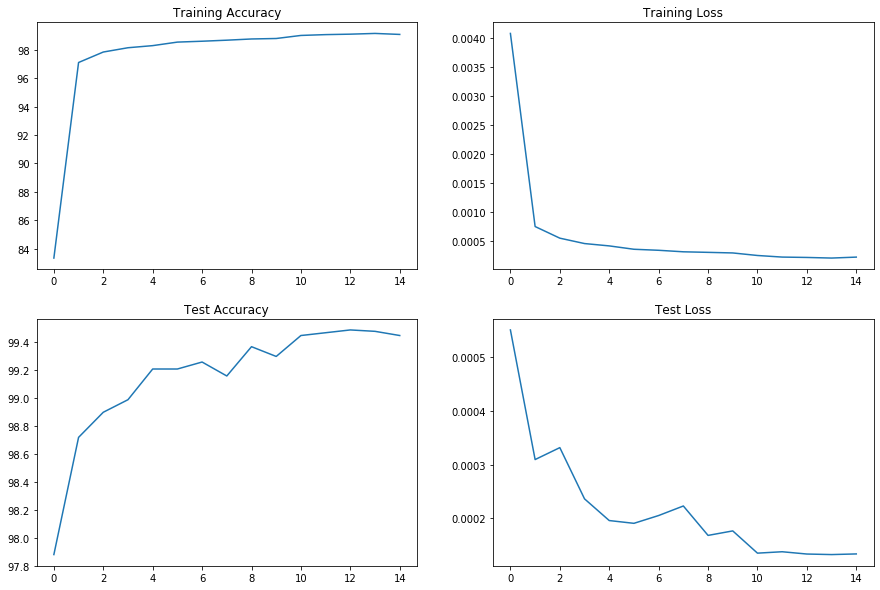

In [16]:
fig, axs = plt.subplots(2,2,figsize=(15, 10))
axs[0, 0].plot(train_accs)
axs[0, 0].set_title("Training Accuracy")
axs[0, 1].plot(train_losses)
axs[0, 1].set_title("Training Loss")
axs[1, 0].plot(test_accs)
axs[1, 0].set_title("Test Accuracy")
axs[1, 1].plot(test_losses)
axs[1, 1].set_title("Test Loss")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1131    0    1    0    1    1    1    0    0]
 [   1    0 1026    0    1    0    1    3    0    0]
 [   0    0    0 1008    0    2    0    0    0    0]
 [   0    0    0    0  979    0    0    1    0    2]
 [   0    0    0    6    0  884    2    0    0    0]
 [   3    2    0    0    0    1  951    0    1    0]
 [   0    4    4    0    0    0    0 1020    0    0]
 [   0    1    1    1    0    1    0    0  967    3]
 [   0    0    0    1    5    0    1    1    0 1001]]


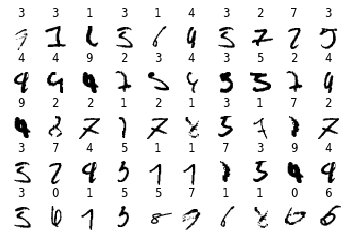

In [28]:
(test_data, test_target, test_prediction, avgTestLoss) = test(net, test_loader)
(miss_data, miss_predictions, miss_targets) = compute_miss(test_data, test_prediction, test_target)

randImages = randInt(0, len(miss_data), 50)
showImages(miss_data[randImages].to(cpu), miss_predictions[randImages].to(cpu))